<a href="https://colab.research.google.com/github/arabporr/Projects/blob/main/BioInformatics_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reza Arabpour
##610397136
###BioInformatics Project Spring 2022

The project documanets are available [here !](https://drive.google.com/file/d/1h-xg0PDQtVR5YUgTb8v0pVd3tcTRwweN/view?usp=sharing)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import sklearn.preprocessing
import networkx as nx
from matplotlib.pylab import show, cm, axis
import random

#Sample Dataset Loading and Graph Creating

###Data Downloader

In [ ]:
!rm -rf 17285561/
!wget https://sgd-prod-upload.s3.amazonaws.com/S000254563/17285561.zip
!unzip 17285561.zip
!pip install --upgrade xlrd

--2022-07-31 11:05:59--  https://sgd-prod-upload.s3.amazonaws.com/S000254563/17285561.zip
Resolving sgd-prod-upload.s3.amazonaws.com (sgd-prod-upload.s3.amazonaws.com)... 52.218.220.91
Connecting to sgd-prod-upload.s3.amazonaws.com (sgd-prod-upload.s3.amazonaws.com)|52.218.220.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2466103 (2.4M) [text/plain]
Saving to: ‘17285561.zip.2’

17285561.zip.2      100%[===================>]   2.35M  2.51MB/s    in 0.9s    

2022-07-31 11:06:00 (2.51 MB/s) - ‘17285561.zip.2’ saved [2466103/2466103]

Archive:  17285561.zip
   creating: 17285561/
  inflating: 17285561/pro200600448_1_s.xls  
  inflating: 17285561/pro200600448_2_s.xls  
  inflating: 17285561/pro200600448_3_s.xls  
  inflating: 17285561/pro200600448_s.pdf  
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Data Loader

In [ ]:
dataset = pd.read_excel(r'17285561/pro200600448_1_s.xls')
dataset = dataset.drop(columns = ["Data sets", "# supporting data sets"])
dataset

,Score,Protein A,Protein B
0,146.551240,YJR076C,YHR107C
1,133.226849,YKL058W,YOR194C
2,122.185533,YNR006W,YHL002W
3,121.276323,YFL008W,YDL003W
4,119.333177,YIL021W,YOL005C
...,...,...,...
9575,17.025920,YER177W,YLR258W
9576,17.020191,YNL252C,YCR046C
9577,17.019080,YGL111W,YOL077C
9578,17.010697,YHR041C,YLR071C


###Node Relabeling

In [ ]:
proteins = pd.concat([dataset["Protein A"], dataset["Protein B"]]).unique()
prot_encoder = dict(zip(proteins, range(len(proteins))))
graph_data = dataset.copy()
graph_data['a'] = graph_data['Protein A'].apply(lambda x: prot_encoder[x])
graph_data['b'] = graph_data['Protein B'].apply(lambda x: prot_encoder[x])
graph_data = graph_data.drop(columns=["Protein A", "Protein B"])
graph_data

,Score,a,b
0,146.551240,0,1028
1,133.226849,1,2162
2,122.185533,2,1796
3,121.276323,3,1357
4,119.333177,4,502
...,...,...,...
9575,17.025920,351,2063
9576,17.020191,1420,2646
9577,17.019080,1655,1423
9578,17.010697,301,1266


###Creating Adjacency Matrix

In [ ]:
V_graph = len(proteins)
adj_matrix = np.zeros((V_graph, V_graph), dtype=float)
for i in range(len(graph_data)):
    adj_matrix[int(graph_data['a'][i]), int(graph_data['b'][i])] = graph_data["Score"][i]
    adj_matrix[int(graph_data['b'][i]), int(graph_data['a'][i])] = graph_data["Score"][i]
adj_matrix

array([[20.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

###Creatin Canonical Matrix

In [ ]:
canonical_matrix = adj_matrix.copy()
for i in range(len(canonical_matrix)):
        canonical_matrix[i][i] = max(canonical_matrix[i])
canonical_matrix = sklearn.preprocessing.normalize(canonical_matrix, norm="l1", axis=0, copy=True)
canonical_matrix

array([[0.15810861, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.22717369, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.29612897, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.5       , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.5       ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.5       ]])

In [ ]:
# TEST OF CORRECTNESS :
# cnt = 0;
# for i in adj_matrix:
#     if(i.sum() != 0):
#         cnt += 1
# print(cnt == canonical_matrix.sum().round())

#SR-MCL Algortitm Implementation (Task 1)

In [ ]:
from sklearn.preprocessing import normalize
from numpy.linalg import matrix_power

def RegularizationMatrix(M, MG, b):
    m = M.sum(axis=0)
    p = M.T @ m
    for i in p:
        if i != 0:
            i = i**(-b)
    P = np.zeros((M.shape[0], M.shape[0]))
    np.fill_diagonal(P, p)
    MR = MG @ P 
    MR = sklearn.preprocessing.normalize(M, norm="l1", axis=0, copy=False)
    return MR

In [ ]:
def Inflate(Matrix, inflation_ratio, Been_An_Attractor, penalized_ratio):
    for i in range(Matrix.shape[0]):
        Matrix[:,i] = np.power(Matrix[:,i], inflation_ratio * np.power(penalized_ratio, Been_An_Attractor[i]))
    Matrix = sklearn.preprocessing.normalize(Matrix, norm="l1", axis=0, copy=False)
    return Matrix

In [ ]:
def Prune(Matrix, threshold = 0.1):
    pruned = Matrix.copy()
    pruned[pruned < threshold] = 0
    pruned = sklearn.preprocessing.normalize(pruned, norm="l1", axis=0, copy=False)
    return pruned

In [ ]:
from scipy.sparse import isspmatrix, dok_matrix, csc_matrix
def get_clusters(M, a):
        clusters = set()
        matrix = csc_matrix(M)
        for attractor in a:
            cluster = tuple(matrix.getrow(attractor).nonzero()[1].tolist())
            clusters.add(cluster)
        return clusters

In [ ]:
def SR_MCL(MG = canonical_matrix, balance_parameter = 2, inflation_ratio = 2, penalized_ratio = 1.25, iterations = 1):
    Resulting_Clusters = []
    Been_An_Attractor = np.zeros(len(MG))
    Matrix = MG.copy()
    for it in range(iterations):
        print("Iteration ",it+1, " out of ",iterations)
        converged = False
        steps = 0
        while(converged == False):
            last_version = Matrix.copy()
            steps += 1
            MR = RegularizationMatrix(Matrix, MG, balance_parameter)
            Matrix = Matrix @ MR
            Matrix = Inflate(Matrix, inflation_ratio, Been_An_Attractor, penalized_ratio)
            Matrix = Prune(Matrix)
            converged = np.allclose(last_version,Matrix)
            print("\tAt Step : ", steps, " and change from previous step : ",(last_version - Matrix).sum())
        print("\tConverged at step ",steps)
        Attractors = Matrix.diagonal().nonzero()[0]
        print(Attractors,"--------")
        print(Been_An_Attractor)
        for v in Attractors:
            Been_An_Attractor[v] += 1
        Citer = get_clusters(Matrix, Attractors)
        for cl in Citer:
            if cl not in Resulting_Clusters:
                Resulting_Clusters.append(cl)

    return Resulting_Clusters

##Post-Processing

In [ ]:
def qf(C, adj):
    v = len(C)
    if (v <= 2):
        return 0
    E = 0
    for i in range(v):
        for j in range(i + 1, v):
            if(adj[i,j] != 0):
                E += 1
    return 2 * E / (v * (v-1)) * math.sqrt(v)

##Running SR_MCL on WI-PHI dataset (task 2)

In [ ]:
clusters = SR_MCL(canonical_matrix,2, 2, 1.25, 5)

Iteration  1  out of  5
	At Step :  1  and change :  15.00000000000008
	At Step :  2  and change :  -1.0796918914479647e-13
	At Step :  3  and change :  7.099876242477876e-14
	At Step :  4  and change :  9.103828801926284e-15
	At Step :  5  and change :  1.7708057242771247e-14
	At Step :  6  and change :  2.275957200481571e-15
	At Step :  7  and change :  -2.7200464103316335e-15
	At Step :  8  and change :  -1.4432899320127035e-15
	At Step :  9  and change :  8.881784197001252e-16
	At Step :  10  and change :  -4.996003610813204e-16
	At Step :  11  and change :  2.7755575615628914e-16
	At Step :  12  and change :  5.551115123125783e-17
	At Step :  13  and change :  5.551115123125783e-17
	At Step :  14  and change :  0.0
	Converged at step  14
[   0    2    3    6    7   11   12   17   19   20   21   23   24   28
   32   35   37   38   39   41   42   44   46   51   52   55   57   58
   60   62   65   68   69   74   75   76   81   84   85   87   91   92
   94   95   96   98   99  100  10

#Random Graph for testing

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


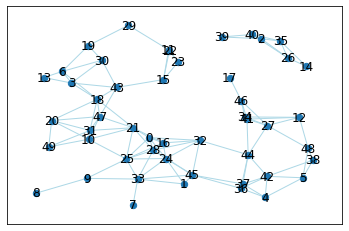

In [ ]:
# Generating a random graph
nodes = 50
positions = {i:(random.random() * 2 - 1, random.random() * 2 - 1) for i in range(nodes)}
graph = nx.random_geometric_graph(nodes, 0.4, pos=positions)
graph.remove_nodes_from(list(nx.isolates(graph)))
nodes = len(graph.nodes)
nx.draw_networkx(graph, pos=positions, node_size=40, with_labels=True, edge_color="lightblue")
A = nx.to_numpy_array(graph)
for i in range(len(A)):
        A[i][i] = max(A[i])
D = sp.sparse.csr_matrix(sp.sparse.spdiags(A.sum(axis=1), 0, nodes, nodes)).toarray()
for i in range(len(A)):
    A[i] = A[i]/(A[i].sum()+0.00000001)
M_G = A @ D
M = M_G.copy()
print(M)

In [ ]:
clusters = SR_MCL(M_G, 1, 4, 1.2, 5)
print(clusters)

Iteration  1  out of  5
	At Step :  1 	At Step :  2 	At Step :  3 	At Step :  4 	At Step :  5 	At Step :  6 	At Step :  7 	At Step :  8 	At Step :  9 	At Step :  10 	At Step :  11 	At Step :  12 	At Step :  13 	At Step :  14 	At Step :  15 	At Step :  16 	At Step :  17 	At Step :  18 	At Step :  19 	At Step :  20 	At Step :  21 	At Step :  22 	At Step :  23 	At Step :  24 	At Step :  25 	At Step :  26 	At Step :  27 	At Step :  28 	At Step :  29 	At Step :  30 	At Step :  31 	At Step :  32 	At Step :  33 	Converged at step  33
[ 1  7  8 13 14 17 22 23 29 34 38 39 49] --------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Iteration  2  out of  5
	At Step :  1 	Converged at step  1
[ 1  7  8 13 14 17 22 23 29 34 38 39 49] --------
[0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]

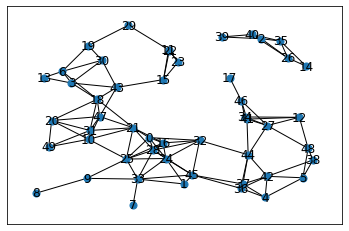

In [ ]:
nx.draw_networkx(graph, pos=positions, node_size=50,  with_labels=True, cmap = 'viridis')

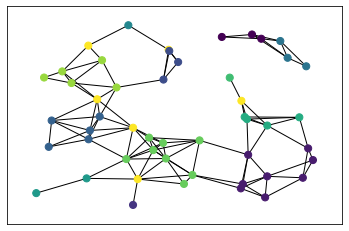

In [ ]:
clusters = list(clusters)
colors = [0 for item in range(nodes)]
for i in range(len(clusters)):
    for nd in clusters[i]:
        if colors[nd] == 0:
            colors[nd] = i
        else:
            colors[nd] = len(clusters)+1
nx.draw_networkx(graph, node_color=colors, pos=positions, node_size=50, with_labels=False, cmap = 'viridis')